<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/representaciones_latentes/autocodificador_variacional_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introducción

Este *notebook* muestra como construir un autocodificador variacional, mejor conocido como Variational Autoencoder (VAE) entrenando un modelo en el conjunto de datos MNIST para generar nuevas imágenes.

Un autocodificador variacional es un modelo generativo basado en probabilidad. Consiste en un codificador, que toma datos x como entrada y los transforma en una representación latente z, y un decodificador, que toma una representación latente z y devuelve una reconstrucción y. La inferencia se realiza a través de la inferencia variacional para aproximar la parte posterior del modelo.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from IPython import display

In [2]:
batch_size = 128
latent_dim = 2

In [3]:
def map_image(image, label):
    image = tf.cast(image, dtype=tf.float32)
    image /= 255.0
    image = tf.reshape(image, shape=(28,28,1,))
    return image

In [4]:
def get_dataset(map_fn, is_validation=False):
    if is_validation:
        split_name = "test"
    else:
        split_name = "train"
  
    dataset = tfds.load("mnist", as_supervised=True, split=split_name)
    dataset = dataset.map(map_fn)

    if is_validation:
        dataset = dataset.batch(batch_size)
    else:
        dataset = dataset.shuffle(1024).batch(batch_size)
  
    return dataset

In [5]:
train_dataset = get_dataset(map_image, is_validation=False)
val_dataset = get_dataset(map_image, is_validation=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [6]:
# Dimensiones del primer lote
list(train_dataset.as_numpy_iterator())[0].shape

(128, 28, 28, 1)

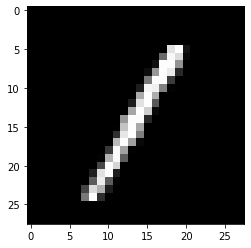

In [7]:
 # Imagen del primer lote
 plt.imshow(list(train_dataset.as_numpy_iterator())[0][0], cmap="gray");

### Codificador

In [8]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mu, sigma = inputs

        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]

        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        return mu + tf.exp(0.5 * sigma) * epsilon

In [9]:
def encoder_layers(inputs, latent_dim):
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu", name="encode_conv1")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu", name="encoder_conv2")(x)

    batch_2 = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Flatten(name="encode_flatten")(batch_2)
    x = tf.keras.layers.Dense(20, activation="relu", name="encoder_dense")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    mu = tf.keras.layers.Dense(latent_dim, name="latent_mu")(x)
    sigma = tf.keras.layers.Dense(latent_dim, name="latent_sigma")(x)

    return mu, sigma, batch_2.shape

In [10]:
def encoder_model(latent_dim, input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    mu, sigma, conv_shape = encoder_layers(inputs, latent_dim=latent_dim)
    z = Sampling()((mu, sigma))
    model = tf.keras.Model(inputs=inputs, outputs=[mu, sigma, z])

    return model, conv_shape

### Decodificador

In [11]:
def decoder_layers(inputs, conv_shape):
    units = conv_shape[1] * conv_shape[2] * conv_shape[3]
    x = tf.keras.layers.Dense(units, activation="relu", name="decode_dense1")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decode_reshape")(x)
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same", activation="relu", name="decode_conv2d_2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu", name="decode_conv2d_3")(x)
    x =tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding="same", activation="sigmoid", name="decode_final")(x)

    return x

In [12]:
def decoder_model(latent_dim, conv_shape):
    inputs = tf.keras.layers.Input(shape=(latent_dim,))
    outputs = decoder_layers(inputs, conv_shape)
    model = tf.keras.Model(inputs, outputs)

    return model

In [13]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
    kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
    kl_loss = tf.reduce_mean(kl_loss) * - 0.5

    return kl_loss

In [14]:
def vae_model(encoder, decoder, input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    mu, sigma, z = encoder(inputs)
    reconstructed = decoder(z)

    model = tf.keras.Model(inputs=inputs, outputs=reconstructed)
    loss = kl_reconstruction_loss(inputs, z, mu, sigma)
    model.add_loss(loss)

    return model

In [15]:
def get_models(input_shape, latent_dim):
    encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
    decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
    vae = vae_model(encoder, decoder, input_shape=input_shape)
    return encoder, decoder, vae

In [16]:
encoder, decoder, vae = get_models(input_shape=(28,28,1,), latent_dim=latent_dim)

In [18]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encode_conv1 (Conv2D)          (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 32)  128         ['encode_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 encoder_conv2 (Conv2D)         (None, 7, 7, 64)     18496       ['batch_normalization[0][0]']

In [19]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 decode_dense1 (Dense)       (None, 3136)              9408      
                                                                 
 batch_normalization_3 (Batc  (None, 3136)             12544     
 hNormalization)                                                 
                                                                 
 decode_reshape (Reshape)    (None, 7, 7, 64)          0         
                                                                 
 decode_conv2d_2 (Conv2DTran  (None, 14, 14, 64)       36928     
 spose)                                                          
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 64)       256 

In [20]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             [(None, 2),          82104       ['input_3[0][0]']                
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 model_1 (Functional)           (None, 28, 28, 1)    78017       ['model[0][2]']                  
                                                                                            

**Por hacer**

* Descripción del modelo VAE
* Entrenamiento de modelo
* Predicciones
* Comentar funciones
* Referencia
